# Calculate wet-bulb temperature with CMIP6 data
This notebook introduces how to use our code to calculate adiabatic wet-bulb temperature (Tw) using the Davies-Jones (2008) approach. Data from a single CMIP6 GCM at 3hourly scale during a 1-month period are obtained from google cloud. Although it is not a big data problem, we still leverge Dask to do calculations lazily and parallelly which will be helpful for users to apply the code to large-size data.

The code was ported from the original Fortran code written by Buzan et al (2015) (https://github.com/jrbuzan/HumanIndexMod_2020). The recently identified errors or inappropriate humidity approximations within the Fortran code have been corrected.

To use our code, please consider cite: *upcoming*

# 1. import packages

### 1.1 import general packages

In [1]:
# import general packages
import xarray as xr
import dask
import dask.array as da
import numpy as np
from matplotlib import pyplot as plt
from numba import njit, vectorize
# import packages needed for obtaining google cloud data
import pandas as pd
import fsspec

### 1.2 import modules for Tw calculation

In [2]:
# import functions for calculating Tw
from wetbulb import Twb_3d

# 2. Read in cmip6 data in google cloud
We will use cmip6 data in google cloud to illustrate how to calculate Tw with our code.

First, read in a csv files that contain the metadata information of cmip6 data that are available in google cloud

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.to_csv('cmip6-zarr-consolidated-stores.csv')

Query the dataframe to get the variables that are needed for calculating Tw. Here we select historical experiment from only one model (CNRM-CM6-1) at 3 hourly frequency.

In [ ]:
print("\nAvailable experiments:", df['experiment_id'].unique())


In [ ]:
print("Available models:", df['source_id'].unique())
print("\nAvailable experiments:", df['experiment_id'].unique())
print("\nAvailable tables:", df['table_id'].unique())
print("\nAvailable variables:", df['variable_id'].unique())
print("\nAvailable members:", df['member_id'].unique())

In [4]:
subset_df=df.query("source_id=='CNRM-CM6-1'& experiment_id=='historical' & table_id=='3hr' & variable_id==['tas', \
'huss', 'ps'] & member_id=='r1i1p1f2'")
subset_df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
37596,CMIP,CNRM-CERFACS,CNRM-CM6-1,historical,r1i1p1f2,3hr,huss,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180917
37603,CMIP,CNRM-CERFACS,CNRM-CM6-1,historical,r1i1p1f2,3hr,tas,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180917
37604,CMIP,CNRM-CERFACS,CNRM-CM6-1,historical,r1i1p1f2,3hr,ps,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180917


We define functions to read in data with xarray.

In [5]:
def drop_all_bounds(ds):
    """Drop coordinates like 'time_bounds' from datasets,
    which can lead to issues when merging."""
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)
def open_dsets(df):
    """Open datasets from cloud storage and return xarray dataset."""
    dsets = [xr.open_zarr(fsspec.get_mapper(ds_url), consolidated=True)
             .pipe(drop_all_bounds)
             for ds_url in df.zstore]
    return dsets

read in data and store multiple xarray dataset within a dictionary

In [6]:
dsets = dict() 
for group, df in subset_df.groupby(by=['variable_id']):
    dsets[group] = open_dsets(df)

/tmp/ipykernel_2055123/125093912.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group, df in subset_df.groupby(by=['variable_id']):


Here we access each variable. We just select one month (2001-07) as an example. We use Dask to chunk the data along 'time' dimension with a chunksize of 8 time steps. Notice that for such a small data, it may be not beneficial to use Dask. But, when you are doing real calculations with large dataset, Dask can be handy to avoid loading too much data into memory and perform parallel computing.

In [7]:
huss=dsets['huss'][0].huss.sel(time='2001-07').chunk({'time':8}) #specific humidity
tas=dsets['tas'][0].tas.sel(time='2001-07').chunk({'time':8}) # 2m air temperature
ps=dsets['ps'][0].ps.sel(time='2001-07').chunk({'time':8}) # surface air pressure

# 3. Calculate Tw

In [8]:
Tw=xr.apply_ufunc(Twb_3d,tas,huss,ps,dask="parallelized",output_dtypes=[float])

Let's plot calculated Tw at the last time step

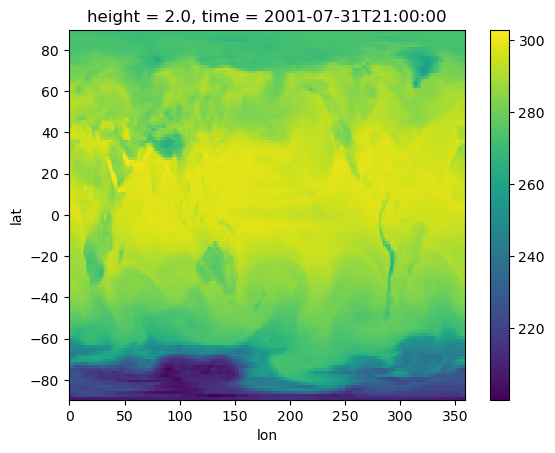

In [10]:
Tw[-1,:,:].plot()

# References

Davies-Jones, R. An Efficient and Accurate Method for Computing the Wet-Bulb Temperature along Pseudoadiabats. Monthly Weather Review 136, 2764–2785 (2008).

Buzan, J. R., Oleson, K. & Huber, M. Implementation and comparison of a suite of heat stress metrics within the Community Land Model version 4.5. Geosci. Model Dev. 8, 151–170 (2015).
